# Credit Risk Modelling: Project
Antoni Ballaun, Laura Hoang, Jędrzej Joniec, Piotr Zambrzycki

## 04. Models: logistic regression

In [10]:
import os

In [14]:
os.chdir('C:/Users/zambr/Desktop/Studia/Semestr 2/Modelowanie ryzyka kredytowego/projekt/MRK-projekt-main')

In [15]:
# --- 1. Importy ---
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    f1_score
)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 5)


In [16]:
# --- 2. Wczytanie danych -----------------
X_train = pd.read_csv("X_train_woe.csv")
X_test  = pd.read_csv("X_test_woe.csv")

y_train = pd.read_csv("y_train.csv").squeeze()
y_test  = pd.read_csv("y_test.csv").squeeze()

print("Shapes  →  X_train:", X_train.shape, "  X_test:", X_test.shape)
print("Target balance (train):")
print(y_train.value_counts(normalize=True).rename("share").to_frame())


Shapes  →  X_train: (91844, 21)   X_test: (22961, 21)
Target balance (train):
              share
Defaulted          
0          0.852141
1          0.147859


In [17]:
# --- 3. Model bazowy ----------------------
log_reg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight="balanced"
)
log_reg.fit(X_train, y_train)
print("Model fitted.")


Model fitted.


              precision    recall  f1-score   support

           0     0.9452    0.7301    0.8238     19553
           1     0.3284    0.7570    0.4581      3408

    accuracy                         0.7341     22961
   macro avg     0.6368    0.7436    0.6410     22961
weighted avg     0.8536    0.7341    0.7696     22961

ROC-AUC: 0.8274


C:\Users\zambr\.julia\conda\3\x86_64\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


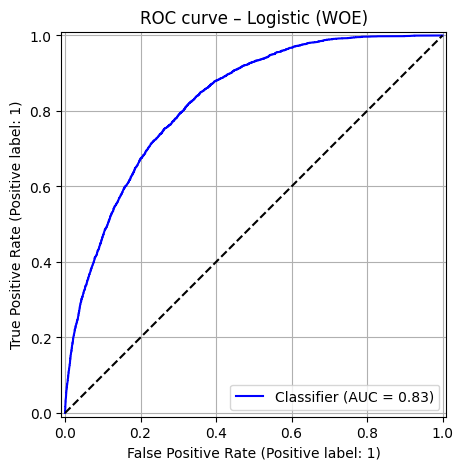

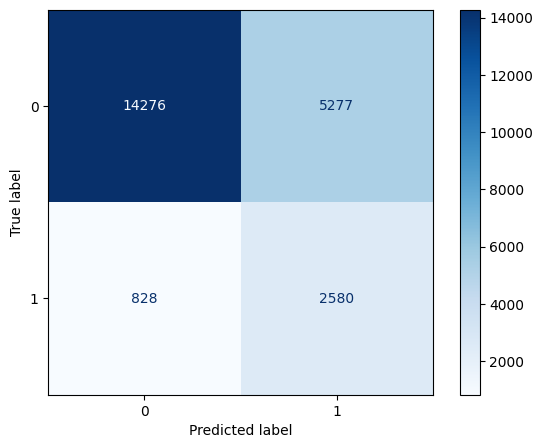

In [32]:
# --- 4. Predykcje i metryki ---------------
y_pred  = log_reg.predict(X_test)
y_prob  = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))


disp = RocCurveDisplay.from_predictions(y_test, y_prob, color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.grid(True)
plt.title("ROC curve – Logistic (WOE)")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.show()


Najlepszy próg wg F1-score: 0.60


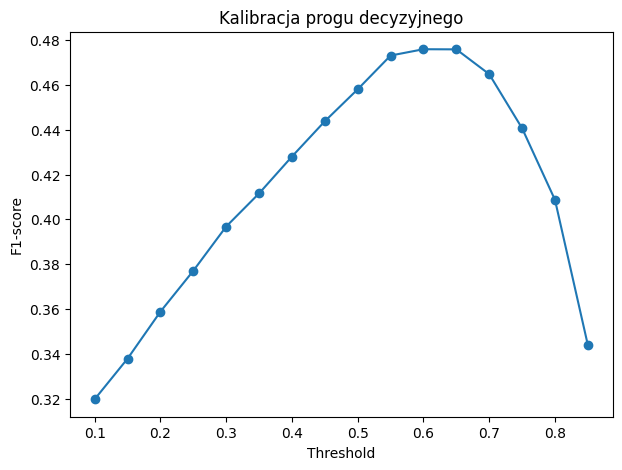

              precision    recall  f1-score   support

           0       0.93      0.82      0.87     19553
           1       0.38      0.63      0.48      3408

    accuracy                           0.79     22961
   macro avg       0.65      0.73      0.67     22961
weighted avg       0.85      0.79      0.81     22961



In [19]:
# --- 5. Kalibracja progu ------------------
thresholds = np.arange(0.1, 0.9, 0.05)
scores = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    score = f1_score(y_test, y_pred_thresh)
    scores.append(score)

best_thresh = thresholds[np.argmax(scores)]
print(f"Najlepszy próg wg F1-score: {best_thresh:.2f}")

plt.plot(thresholds, scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('Kalibracja progu decyzyjnego')
plt.show()

y_pred_calibrated = (y_prob >= best_thresh).astype(int)
print(classification_report(y_test, y_pred_calibrated))


In [20]:
# --- 6. Zapis wytrenowanego modelu --------
import joblib, os
os.makedirs("models", exist_ok=True)

joblib.dump(log_reg, "models/logreg_woe.pkl")
print("Model zapisany → models/logreg_woe.pkl")


Model zapisany → models/logreg_woe.pkl


In [25]:
# --- 7. Automatyczny raport podsumowujący ---
from sklearn.metrics import roc_auc_score, f1_score

print("\n" + "="*30)
print("RAPORT MODELU KREDYTOWEGO")
print("="*30)

# Dane
print("\nLiczność zbiorów danych:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test : {X_test.shape} | y_test : {y_test.shape}")

# Default rate
print("\nDefault rate (train vs test):")
print(f"Train: {y_train.mean():.4f} ({y_train.sum()}/{len(y_train)})")
print(f"Test : {y_test.mean():.4f} ({y_test.sum()}/{len(y_test)})")

# Wyniki modelu bazowego
print("\n--- Model bazowy (Logistic Regression) ---")
print("Accuracy na zbiorze testowym:", (y_pred == y_test).mean().round(4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))

# Wyniki po kalibracji
print("\n--- Model po kalibracji progu ---")
print(f"Optymalny próg (F1-score) = {best_thresh:.2f}")
y_pred_calibrated = (y_prob >= best_thresh).astype(int)
print("Accuracy:", (y_pred_calibrated == y_test).mean().round(4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))
print("F1-score:", round(f1_score(y_test, y_pred_calibrated), 4))

# Selekcja zmiennych (L1) — jeśli używasz L1-penalty w regresji logistycznej
print("\n--- Selekcja zmiennych (L1) ---")
n_selected = (log_reg.coef_[0] != 0).sum()
total_vars = log_reg.coef_.shape[1]
print(f"Liczba zmiennych wybranych przez L1: {n_selected}/{total_vars}")



RAPORT MODELU KREDYTOWEGO

Liczność zbiorów danych:
X_train: (91844, 21) | y_train: (91844,)
X_test : (22961, 21) | y_test : (22961,)

Default rate (train vs test):
Train: 0.1479 (13580/91844)
Test : 0.1484 (3408/22961)

--- Model bazowy (Logistic Regression) ---
Accuracy na zbiorze testowym: 0.7341
ROC-AUC: 0.8274

--- Model po kalibracji progu ---
Optymalny próg (F1-score) = 0.60
Accuracy: 0.7932
ROC-AUC: 0.8274
F1-score: 0.4759

--- Selekcja zmiennych (L1) ---
Liczba zmiennych wybranych przez L1: 21/21


In [26]:
gini = 2 * roc_auc_score(y_test, y_prob) - 1
print("Gini:", round(gini, 4))

Gini: 0.6548


In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score

# Ustal próg decyzyjny
threshold = 0.6

# Predykcje prawdopodobieństwowe i klasy przy zadanym progu
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_pred_proba >= threshold).astype(int)

# Raport i macierz pomyłek
print(f"=== Final Classification Report @ {threshold:.2f} ===")
print(classification_report(y_test, y_pred_thresh, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))

# Precision osobno
precision = precision_score(y_test, y_pred_thresh)
print(f"Precision @ {threshold:.2f}: {precision:.4f}")

# AUC i Gini
roc_auc = roc_auc_score(y_test, y_pred_proba)
gini = 2 * roc_auc - 1
print(f"AUC: {roc_auc:.4f}")
print(f"Gini: {gini:.4f}")

=== Final Classification Report @ 0.60 ===
              precision    recall  f1-score   support

           0     0.9277    0.8212    0.8712     19553
           1     0.3815    0.6326    0.4759      3408

    accuracy                         0.7932     22961
   macro avg     0.6546    0.7269    0.6736     22961
weighted avg     0.8466    0.7932    0.8125     22961

Confusion Matrix:
[[16057  3496]
 [ 1252  2156]]
Precision @ 0.60: 0.3815
AUC: 0.8274
Gini: 0.6548
